# Soft Actor-Critic (SAC) with PyTorch

In this notebook we will look at Soft Actor-Critic (SAC) algorithm using PyTorch. It builds on what we saw in `listing8_2` for TD3. However, it is not further improvement of TD3, rather something that came out in parallel of TD3.

Click here to access the paper which proposed SAC originally: https://arxiv.org/pdf/1802.09477.pdf

SAC forms a bridge between DDPG style deterministic policy gradients and stochastic policy optimization. 

##### SAC vs TD3

Similar:
1. Both use Mean Squared Bellman Error(MSBE) minimization towards a common target
2. Common target is calculated using target Q networks which are obtained using polyack averaging
3. Both use clipped double Q - minimum of two Q values to avoid overestimation

Different:
1. SAC uses entropy regularization which is absent in TD3
2. In TD3 target-policy is used to calculate the next-state-actions while, in SAC we use **current policy** to get actions for next_states
3. In TD3 target_policy uses smoothing by adding random noise to actions, However, in SAC the policy learnt is a stochastic one which provides a smoothing effect without any explicit noise addition.

#### Q-Loss with Entropy-Regularization

Entropy measures randomness in the distribution. Higher the entropy, higher (or flatter) is the distribution. A sharp peaked policy has all its probability centered around that peak and hence it will have low entropy. Entropy is given by:

$$H(P) = \underset{x \sim P}{E}\left[{-\log P(x)}\right] \;\;\;\;\text{where P is distribution of random variable x}$$

With entropy regularization, the policy is trained to maximize a trade-off between expected return and entropy with  $\alpha$ controlling the trade-off. The updated maximization problem is:

The policy is trained to maximize a trade-off between expected return and entropy, a measure of randomness in the policy.

$$\pi^* = \arg \max_{\pi} \underset{\tau \sim \pi}{E}\left[{ \sum_{t=0}^{\infty} \gamma^t \left( R(s_t, a_t, s_{t+1}) + \alpha H(\pi(\cdot|s_t)) \right)}\right]$$

In this setting, $V^{\pi}$ is changed to include the entropy from every time step:

$$V^{\pi}(s) = \underset{\tau \sim \pi}{E} \left[{ \left. \sum_{t=0}^{\infty} \gamma^t \left( R(s_t, a_t, s_{t+1}) + \alpha H\left(\pi(\cdot|s_t)\right) \right) \right| s_0 = s} \right]$$

and, $Q^{\pi}$ is changed to include the entropy bonuses from every time step except the first:

$$Q^{\pi}(s,a) = \underset{\tau \sim \pi}{E}\left[{ \left. \sum_{t=0}^{\infty} \gamma^t  R(s_t, a_t, s_{t+1}) + \alpha \sum_{t=1}^{\infty} \gamma^t H\left(\pi(\cdot|s_t)\right)\right| s_0 = s, a_0 = a}\right]$$

With these definitions, $V^{\pi}$ and $Q^{\pi}$ are connected by:

$$V^{\pi}(s) = \underset{a \sim \pi}{E}{Q^{\pi}(s,a)} + \alpha H\left(\pi(\cdot|s)\right)$$

and the Bellman equation for $Q^{\pi}$ is

$$Q^{\pi}(s,a) = \underset{s' \sim P \\ a' \sim \pi}E[\left[{R(s,a,s') + \gamma\left(Q^{\pi}(s',a') + \alpha H\left(\pi(\cdot|s')\right) \right)} \right]\\
= \underset{s' \sim P}E\left[{R(s,a,s') + \gamma V^{\pi}(s')}\right].$$

The right hand side is an expectation which we will now convert into a sample estimate.


$$Q^{\pi}(s,a) \approx r + \gamma\left(Q^{\pi}(s',\tilde{a}') - \alpha \log \pi(\tilde{a}'|s') \right), \;\;\;\;\;  \tilde{a}' \sim \pi(\cdot|s')$$

where(s,a,r,s') come form replay buffer and $\tilde{a}'$ comes from sampling the online/agent policy. In SAC, we do not use target network policy at all. 


Like TD3, SAC uses clipped Double Q and minimizes Mean Squared Bellman Error (MSBE). Putting it all together, the loss functions for the Q-networks in SAC are:

$$L(\phi_i, {\mathcal D}) = \underset{(s,a,r,s',d) \sim {\mathcal D}}{{\mathrm E}}\left[
    \left( Q_{\phi_i}(s,a) - y(r,s',d) \right)^2
    \right], \;\;\;\;\; i=1,2$$
    
where the target is given by

$$y(r, s', d) = r + \gamma (1 - d) \left( \min_{i=1,2} Q_{\phi_{\text{targ},i}}(s', \tilde{a}') - \alpha \log \pi_{\theta}(\tilde{a}'|s') \right), \;\;\;\;\; \tilde{a}' \sim \pi_{\theta}(\cdot|s')$$


We now convert expectations to sample averages:

$$L(\phi_i, {\mathcal D}) = \frac{1}{|B|}\sum_{(s,a,r,s',d) \in B} \left( Q_{\phi_i}(s,a) - y(r,s',d) \right)^2, \;\;\;\;\; \text{for } i=1,2$$

The final Q Loss we will minimize is:

$$Q_{Loss} = L(\phi_1, {\mathcal D}) + L(\phi_1, {\mathcal D})$$



#### Policy Loss with Reparameterization Trick

The policy should choose actions to maximize the expected future return and future entropy i.e. V^\pi\left(s\right):

$$V^\pi\left(s\right)= \underset{a\sim\pi}{E}[Q^\pi\left(s,a\right)+\alpha H\left(\pi\left(\cdot\middle| s\right)\right)]$$

We rewrite this as:

$$V^\pi\left(s\right)= \underset{a\sim\pi}{E}[Q^\pi\left(s,a\right)\ -\ \alpha\ log\ \pi\left(a\middle| s\right)]$$

The Authors of the paper, use reparameterization along with squashed Gaussian policy:

$$\tilde{a_\theta}\left(s,\xi\right)=\tanh{\left(\mu_\theta\left(s\right)+\sigma_\theta\left(s\right)\odot\xi\right)},\;\;\;\;\;\xi\sim\mathcal{N}\left(0,I\right)$$

Combining last two equations, and also noting that our policy network is parameterized by θ, the policy network weights, we get:

$$\underset{a \sim \pi_{\theta}}{E}[{Q^{\pi_{\theta}}(s,a) - \alpha \log \pi_{\theta}(a|s)}] = \underset{\xi \sim \mathcal{N}}{E}[{Q^{\pi_{\theta}}(s,\tilde{a}_{\theta}(s,\xi)) - \alpha \log \pi_{\theta}(\tilde{a}_{\theta}(s,\xi)|s)}]$$


Next, we substitute the function approximator for Q taking min of the two Q-functions. 

$$ Q^{\pi_{\theta}}(s,\tilde{a}_{\theta}(s,\xi)) = \min_{i=1,2} Q_{\phi_i}(s,\tilde{a}_{\theta}(s,\xi))$$

The Policy Objective is given by:

$$\max_{\theta} \underset{s \sim \mathcal{D} \\ \xi \sim \mathcal{N}}{E}\left[ {\min_{i=1,2} Q_{\phi_i}(s,\tilde{a}_{\theta}(s,\xi)) - \alpha \log \pi_{\theta}(\tilde{a}_{\theta}(s,\xi)|s)} \right]$$

Like before, we use minimizers in PyTorch/TensorFlow. Accordingly, we introduce a -ve sign to convert maximization to a Loss minimization:

$$Policy_{Loss} = - \underset{s \sim \mathcal{D} \\ \xi \sim \mathcal{N}}{E}\left[ {\min_{i=1,2} Q_{\phi_i}(s,\tilde{a}_{\theta}(s,\xi)) - \alpha \log \pi_{\theta}(\tilde{a}_{\theta}(s,\xi)|s)} \right]$$

Next we convert the expectation to estimate using samples to get:

$$Policy_{Loss} = - \frac{1}{|B|}\sum_{s \in B} \left(\min_{i=1,2} Q_{\phi_i}(s, \tilde{a}_{\theta}(s)) - \alpha \log \pi_{\theta} \left(\left. \tilde{a}_{\theta}(s) \right| s\right) \right)$$


You can read more about Reparameterization and Stochastic Graphs in [Gradient Estimation Using
Stochastic Computation Graphs](https://arxiv.org/pdf/1506.05254.pdf)



***
**Soft Actor Critic (SAC)**
***
 
1. Input initial policy parameters $\theta$,  Q-function parameters $\phi_1$ and $\phi_2$, empty replay buffer D

2. Set target parameters equal to online parameters $\phi_{targ,1} \leftarrow \phi_1$ and $\phi_{targ,2} \leftarrow \phi_2$

3. **repeat**

4. Observe state s and select action $a \sim \pi_{\theta}(\cdot|s)$

5. Execute a in environment and observe next state s', reward r, and done signal d

6. Store `(s,a,r,s',d)` in Replay Buffer D

7. if `s'` is terminal state, reset the environment

8. if it's time to update **then**:

9. &emsp;&emsp;for j in range (as many updates as required):

10. &emsp;&emsp;&emsp;&emsp;Sample a batch B={`(s,a,r,s',d)`} from replay Buffer D:

11. &emsp;&emsp;&emsp;&emsp;Compute target for Q functions: 

$$y (r,s',d) = r + \gamma (1-d) \left(\min_{i=1,2} Q_{\phi_{\text{targ}, i}} (s', \tilde{a}') - \alpha \log \pi_{\theta}(\tilde{a}'|s')\right), \;\;\; \tilde{a}' \sim \pi_{\theta}(\cdot|s')$$

12. &emsp;&emsp;&emsp;&emsp;Update Q function with one step gradient descent on $\phi$:
$$\nabla_{\phi_i} \frac{1}{|B|}\sum_{(s,a,r,s',d) \in B} \left( Q_{\phi_i}(s,a) - y(r,s',d) \right)^2, \;\;\;\;\; \text{for } i=1,2$$

13. &emsp;&emsp;&emsp;&emsp;Update policy by one step of gradient ascent using:
$$\nabla_{\theta} \frac{1}{|B|}\sum_{s \in B} \left(\min_{i=1,2} Q_{\phi_i}(s, \tilde{a}_{\theta}(s)) - \alpha \log \pi_{\theta} \left(\left. \tilde{a}_{\theta}(s) \right| s\right) \right)$$
                      
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;where $\tilde{a}_{\theta}(s)$ is a sample from $\pi_{\theta}(\cdot|s)$ which is differentiable wrt $\theta$ via the reparameterization trick.

14. &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Update target networks using polyak averaging: 
$$\phi_{targ,i} \leftarrow \rho\phi_{targ,i} + (1-\rho)\phi_i, \;\;\;\;\;  \text{for } i=1,2$$ 
***


#### Key Features of SAC

1. SAC is an off-policy algorithm.
2. SAC as implemented can only be used for environments with continuous action spaces. To apply SAC for discrete action space one needs to use Gumbel-Softmax distribution, You can find more about it online.
3. SAC learns stochastic policies and is seen as extension of Actor Critic family. 



#### Our Implementation
This notebook follows the code found in OpenAI's [Spinning Up Library](https://spinningup.openai.com/en/latest/algorithms/sac.html). In this notebook we have broken the code into separate code cells with required explanations. Also some of the implementations like ReplayBuffer have been borrowed from our past notebooks to provide continuity. Further some codes like building of networks have been simplified resulting in easier to understand but more verbose code. 

In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions.normal import Normal

from copy import deepcopy
import gym


import os
import io
import base64
import time
import glob
from IPython.display import HTML

%matplotlib inline

### Environment - Pendulum

We can use the setup here to run on any environment which has state as a single vector and actions are continuous. We will build it on `Pendulum-v0`.

In [2]:
def make_env(env_name, seed=None):
    # remove time limit wrapper from environment
    env = gym.make(env_name).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

State shape: (3,)
Action shape: (1,)


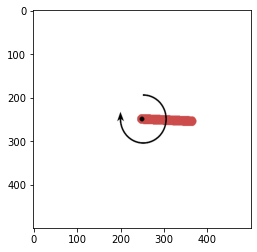

In [3]:
env_name = 'Pendulum-v0'

env = make_env(env_name)
env.reset()
plt.imshow(env.render("rgb_array"))
state_shape, action_shape = env.observation_space.shape, env.action_space.shape
print('State shape: {}'.format(state_shape))
print('Action shape: {}'.format(action_shape))
env.close()

### Build Policy network (Actor)
It is a simple 2 hidden layer network which takes state as input and produces the mean $\mu$ and $\log(\sigma)$ of a normal distribution from which actions are sampled. Calculating $logprob$ requires understanding reparameterization of density distributions, a short explanation is given in Appendix C of the SAC paper

In [4]:
LOG_STD_MAX = 2
LOG_STD_MIN = -20

class SquashedGaussianMLPActor(nn.Module):
    def __init__(self, state_dim, act_dim, act_limit):
        super().__init__()
        self.act_limit = act_limit
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.mu_layer = nn.Linear(256, act_dim)
        self.log_std_layer = nn.Linear(256, act_dim)
        self.act_limit = act_limit
    
    def forward(self, s, deterministic=False, with_logprob=True):
        x = self.fc1(s)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        mu = self.mu_layer(x)
        log_std = self.log_std_layer(x)
        log_std = torch.clamp(log_std, LOG_STD_MIN, LOG_STD_MAX)
        std = torch.exp(log_std)
        
        # Pre-squash distribution and sample
        pi_distribution = Normal(mu, std)
        if deterministic:
            # Only used for evaluating policy at test time.
            pi_action = mu
        else:
            pi_action = pi_distribution.rsample()

        if with_logprob:
            # Compute logprob from Gaussian, and then apply correction for Tanh squashing.
            # NOTE: The correction formula is a little bit magic. To get an understanding 
            # of where it comes from, check out the original SAC paper (arXiv 1801.01290) 
            # and look in appendix C. This is a more numerically-stable equivalent to Eq 21.
            # Try deriving it yourself as a (very difficult) exercise. :)
            logp_pi = pi_distribution.log_prob(pi_action).sum(axis=-1)
            logp_pi -= (2*(np.log(2) - pi_action - F.softplus(-2*pi_action))).sum(axis=1)
        else:
            logp_pi = None

        pi_action = torch.tanh(pi_action)
        pi_action = self.act_limit * pi_action

        return pi_action, logp_pi    

### Build Q-network network (Critic)
It is a simple 2 hidden layer network which takes state and action as input and produces Q-value as output. We will have two versions of Q-network as Critic

In [5]:
class MLPQFunction(nn.Module):
    def __init__(self, state_dim, act_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim+act_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.Q = nn.Linear(256, 1)
    
    def forward(self, s, a):
        x = torch.cat([s,a], dim=-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        q = self.Q(x)
        return torch.squeeze(q, -1)
        

### Combine Actor and Critic into a single model

One policy Network and Two Q-networks as discussed above:

In [6]:
class MLPActorCritic(nn.Module):
    def __init__(self, observation_space, action_space):
        super().__init__()
        self.state_dim = observation_space.shape[0]
        self.act_dim = action_space.shape[0]
        self.act_limit = action_space.high[0]
        
        #build Q and policy functions
        self.q1 = MLPQFunction(self.state_dim, self.act_dim)
        self.q2 = MLPQFunction(self.state_dim, self.act_dim)
        self.policy = SquashedGaussianMLPActor(self.state_dim, self.act_dim, self.act_limit)
        
    def act(self, state, deterministic=False):
        with torch.no_grad():
            a, _ = self.policy(state, deterministic, False)
            return a.numpy()
    
    def get_action(self, state, deterministic=False):
        return self.act(torch.as_tensor(state, dtype=torch.float32), 
                      deterministic)        

### Experience replay

We will use the replay buffer we saw in chapter 4 listings. Replay buffer is very important in DQN to break the correlation between samples. We use a behavior policy ($\epsilon-greedy$) to sample from the environment and store the transitions (s,a,r,s',done) into a buffer. These samples are used multiple times in a learning making the process sample efficient. 

The interface to ReplayBuffer is:
* `exp_replay.add(state, action, reward, next_state, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns states, actions, rewards, next_states and done_flags for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.



In [7]:
class ReplayBuffer:
    def __init__(self, size=1e6):
        self.size = size #max number of items in buffer
        self.buffer =[] #array to holde buffer
        self.next_id = 0
    
    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        if len(self.buffer) < self.size:
            self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.next_id = (self.next_id + 1) % self.size
        
    def sample(self, batch_size=32):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(done_flags)
    

### Q-loss

Compute Q-loss as per equations above:

In [8]:

def compute_q_loss(agent, target_network, states, actions, rewards, next_states, done_flags,
                    gamma, alpha, act_limit):
    
    # convert numpy array to torch tensors
    states = torch.tensor(states, dtype=torch.float)
    actions = torch.tensor(actions, dtype=torch.float)
    rewards = torch.tensor(rewards, dtype=torch.float)
    next_states = torch.tensor(next_states, dtype=torch.float)
    done_flags = torch.tensor(done_flags.astype('float32'),dtype=torch.float)
    
    # get q-values for all actions in current states
    # use agent network
    q1 = agent.q1(states, actions)
    q2 = agent.q2(states, actions)
    
    # Bellman backup for Q function
    with torch.no_grad():
        
        action_target, action_target_logp = target_network.policy(next_states)
        
        # Target Q            
        q1_target = target_network.q1(next_states, action_target)
        q2_target = target_network.q2(next_states, action_target)
        q_target = torch.min(q1_target, q2_target) 
        target = rewards + gamma * (1 - done_flags) * (q_target-alpha*action_target_logp)

    # MSE loss against Bellman backup
    loss_q1 = ((q1 - target)**2).mean()
    loss_q2 = ((q2 - target)**2).mean()
    loss_q = loss_q1 + loss_q2
    
    return loss_q

### Policy-Loss

Compute Policy Loss as per equations above:
    
Please note the `-` sign. We need to do gradient ascent but PyTorch does gradient descent. We convert the ascent to descent using a -ve sign. 

In [9]:
def compute_policy_loss(agent, states, alpha):
    
    # convert numpy array to torch tensors
    states = torch.tensor(states, dtype=torch.float)
    
    actions, actions_logp = agent.policy(states)
    
    q1_values = agent.q1(states, actions)
    q2_values = agent.q2(states, actions)
    q_values = torch.min(q1_values, q2_values)
    
    # Entropy regularised
    loss_policy = - (q_values - alpha*actions_logp).mean()
    return loss_policy

### One step gradient Descent on both Policy(Actor) and Q-value(Critic)

In [10]:
def one_step_update(agent, target_network, q_params, q_optimizer, policy_optimizer, 
                    states, actions, rewards, next_states, done_flags,
                    gamma, polyak, alpha, act_limit):
    
    #one step gradient for q-values
    q_optimizer.zero_grad()
    loss_q = compute_q_loss(agent, target_network, states, actions, rewards, next_states, done_flags,
                    gamma, alpha, act_limit)
    
    loss_q.backward()
    q_optimizer.step()
    
    #Freeze Q-network
    for params in q_params:
        params.requires_grad = False

    #one setep gradient for policy network
    policy_optimizer.zero_grad()
    loss_policy = compute_policy_loss(agent, states, alpha)
    loss_policy.backward()
    policy_optimizer.step()

    #UnFreeze Q-network
    for params in q_params:
        params.requires_grad = True


    # update target networks with polyak averaging
    with torch.no_grad():
        for params, params_target in zip(agent.parameters(), target_network.parameters()):
            params_target.data.mul_(polyak)
            params_target.data.add_((1-polyak)*params.data)

### To Test performance of agent without any stochasticity i.e. perform deterministic actions

In [11]:
def test_agent(env, agent, num_test_episodes, max_ep_len):
    ep_rets, ep_lens = [], []
    for j in range(num_test_episodes):
        state, done, ep_ret, ep_len = env.reset(), False, 0, 0
        while not(done or (ep_len == max_ep_len)):
            # Take deterministic actions at test time 
            state, reward, done, _ = env.step(agent.get_action(state, True))
            ep_ret += reward
            ep_len += 1
        ep_rets.append(ep_ret)
        ep_lens.append(ep_len)
    return np.mean(ep_rets), np.mean(ep_lens)


### SAC Algorithm

We pull all the pieces together to train the agent

In [12]:
def sac(env_fn, seed=0, 
         steps_per_epoch=4000, epochs=5, replay_size=int(1e6), gamma=0.99, 
         polyak=0.995, policy_lr=1e-3, q_lr=1e-3, alpha=0.2, batch_size=100, start_steps=10000, 
         update_after=1000, update_every=50, num_test_episodes=10, max_ep_len=1000):
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    env, test_env = env_fn(), env_fn()
    
    ep_rets, ep_lens = [], []

    state_dim = env.observation_space.shape
    act_dim = env.action_space.shape[0]
    
    act_limit = env.action_space.high[0]
    
    agent = MLPActorCritic(env.observation_space, env.action_space)
    target_network = deepcopy(agent)
    
    
    # Freeze target networks with respect to optimizers (only update via polyak averaging)
    for params in target_network.parameters():
        params.requires_grad = False
    
    
    # Experience buffer
    replay_buffer = ReplayBuffer(replay_size)
    
    # List of parameters for both Q-networks 
    q_params = itertools.chain(agent.q1.parameters(), agent.q2.parameters())

    #optimizers
    q_optimizer = Adam(q_params, lr=q_lr)
    policy_optimizer = Adam(agent.policy.parameters(), lr=policy_lr)
    
    total_steps = steps_per_epoch*epochs
    state, ep_ret, ep_len = env.reset(), 0, 0
    
    for t in range(total_steps):
        if t > start_steps:
            action = agent.get_action(state)
        else:
            action = env.action_space.sample()
            
        next_state, reward, done, _ = env.step(action)
        ep_ret += reward
        ep_len += 1
        
        # Ignore the "done" signal if it comes from hitting the time
        # horizon (that is, when it's an artificial terminal signal
        # that isn't based on the agent's state)
        done = False if ep_len==max_ep_len else done
        
        # Store experience to replay buffer
        replay_buffer.add(state, action, reward, next_state, done)
        
        state = next_state
        
        # End of trajectory handling
        if done or (ep_len == max_ep_len):
            ep_rets.append(ep_ret)
            ep_lens.append(ep_len)
            state, ep_ret, ep_len = env.reset(), 0, 0
        
        # Update handling
        if t >= update_after and t % update_every == 0:
            for j in range(update_every):
                states, actions, rewards, next_states, done_flags = replay_buffer.sample(batch_size)
                
                one_step_update(
                        agent, target_network, q_params, q_optimizer, policy_optimizer, 
                        states, actions, rewards, next_states, done_flags,
                        gamma, polyak, alpha, act_limit
                )
                        
        # End of epoch handling
        if (t+1) % steps_per_epoch == 0:
            epoch = (t+1) // steps_per_epoch
            
            avg_ret, avg_len = test_agent(test_env, agent, num_test_episodes, max_ep_len)
            print("End of epoch: {:.0f}, Training Average Reward: {:.0f}, Training Average Length: {:.0f}".format(epoch, np.mean(ep_rets), np.mean(ep_lens)))
            print("End of epoch: {:.0f}, Test Average Reward: {:.0f}, Test Average Length: {:.0f}".format(epoch, avg_ret, avg_len))
            ep_rets, ep_lens = [], []
    
    return agent

### Train the agent

In [13]:
env_name = 'Pendulum-v0'
agent = sac(lambda : make_env(env_name))

End of epoch: 1, Training Average Reward: -5068, Training Average Length: 1000
End of epoch: 1, Test Average Reward: -255, Test Average Length: 1000
End of epoch: 2, Training Average Reward: -6206, Training Average Length: 1000
End of epoch: 2, Test Average Reward: -132, Test Average Length: 1000
End of epoch: 3, Training Average Reward: -3609, Training Average Length: 1000
End of epoch: 3, Test Average Reward: -173, Test Average Length: 1000
End of epoch: 4, Training Average Reward: -157, Training Average Length: 1000
End of epoch: 4, Test Average Reward: -165, Test Average Length: 1000
End of epoch: 5, Training Average Reward: -95, Training Average Length: 1000
End of epoch: 5, Test Average Reward: -149, Test Average Length: 1000


**Let us record a video of trained agent**

In [14]:
def generate_animation(env, agent, save_dir):
    
    try:
        env = gym.wrappers.Monitor(
            env, save_dir, video_callable=lambda id: True, force=True, mode='evaluation')
    except gym.error.Error as e:
        print(e)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    state, done, ep_ret, ep_len = env.reset(), False, 0, 0
    while not done:
        # Take deterministic actions at test time
        state, reward, done, _ = env.step(agent.get_action(state, True))
        ep_ret += reward
        ep_len += 1

    print('Reward: {}'.format(ep_ret))
    env.close()
            
def display_animation(filepath):
    video = io.open(filepath, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii')))

In [15]:
# Animate learned policy
save_dir='./videos/pytorch/sac/pendulum'
env = gym.make(env_name)
generate_animation(env, agent, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)


Reward: -2.6907421772405864


#### Train and evaluate performance on LunarLander Environment

In [16]:
# Train
env_name = 'LunarLanderContinuous-v2'
agent1 = sac(lambda : make_env(env_name))

# Animate learned policy
save_dir='./videos/pytorch/sac/lunar'
env = gym.make(env_name)
generate_animation(env, agent1, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)

End of epoch: 1, Training Average Reward: -220, Training Average Length: 108
End of epoch: 1, Test Average Reward: -66, Test Average Length: 436
End of epoch: 2, Training Average Reward: -222, Training Average Length: 111
End of epoch: 2, Test Average Reward: -14, Test Average Length: 280
End of epoch: 3, Training Average Reward: -195, Training Average Length: 179
End of epoch: 3, Test Average Reward: -136, Test Average Length: 312
End of epoch: 4, Training Average Reward: -136, Training Average Length: 590
End of epoch: 4, Test Average Reward: -142, Test Average Length: 581
End of epoch: 5, Training Average Reward: -82, Training Average Length: 583
End of epoch: 5, Test Average Reward: -15, Test Average Length: 631
Reward: -100.36610279423913
